#### Actor Critic Methods

As in REINFORCE with baseline, we have a policy network and a network to predict the V(S) called critic. 
But we update the parameters at each step of the episode instead of waiting for entire episode. The difference is 
analogous to the difference between Monte Carlo and Temporal difference methods. In A2C as well we use TD bootstrapping

$$ Q(s,a) = r + \gamma V(s')$$
$$ Q(s,a) = V(s) + A(a,s)$$
Therefore advantage function, 
$$ A(a,s) = Q(s, a) - V(s)$$
$$ A(a,s) = {\color{#0175c2}r + \gamma V(s')} - V(s)$$

Now the policy gradients:
$$\nabla_{\theta}J(\theta) = \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) {\color{#ed005a}(r + \gamma V_{\phi}(s') - V_{phi}(s)})$$ 

#### <font color="#00ba47">Asynchronous Advantage Actor Critic method</font> (A3C):

Used to train multiple agents in parallel and aggregate their overall experience.
In A3C, we will have two types of networks, one is a global network (global agent), and the other is the worker network (worker agent). We will have many worker agents, each worker agent uses a different exploration policy, and they learn in their own copy of the environment and collect experience. Then, the experience obtained from these worker agents is aggregated and sent to the global agent. The global agent aggregates the learning.

<img src="https://www.oreilly.com/api/v2/epubs/9781788836524/files/assets/c03ff91d-52b4-4cdb-9c5a-30fa27bcdad1.png" width="700">

Actor loss:
$$ J(\theta) = \log \pi_{\theta} (a_t|s_t)(r + \gamma V_{\phi}(s') - V_{phi}) + \color{#ed005a}\beta H(\pi(s))$$
$$H(P) = - \sum_a p(a) \log p(a)$$
The second part is the entropy for exploration 

And critic loss is just the mean squared TD error

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gym
from torch.distributions import Normal
import random
import matplotlib.pyplot as plt
from typing import Tuple, List
from IPython.display import clear_output

In [2]:
def initialize_uniformly(layer: nn.Linear, init_w: float = 3e-3):
    """Initialize the weights and bias in [-init_w, init_w]."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.mu_layer = nn.Linear(128, out_dim)     
        self.log_std_layer = nn.Linear(128, out_dim)   
        
        initialize_uniformly(self.mu_layer)
        initialize_uniformly(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        
        mu = torch.tanh(self.mu_layer(x)) * 2       # pendulum has output in range [-2, 2] so to fit the range
        log_std = F.softplus(self.log_std_layer(x)) # relu but differentiable at x=0
        std = torch.exp(log_std)
        
        dist = Normal(mu, std)
        action = dist.sample()
        
        return action, dist
    
class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.out = nn.Linear(128, 1)
        
        initialize_uniformly(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        value = self.out(x)
        
        return value

In [3]:
class A2CAgent:
    """A2CAgent interacting with environment.
        
    Atribute:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(self, env: gym.Env, gamma: float, entropy_weight: float):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        
        # device: cpu / gpu
        self.device = torch.device("mps" if torch.has_mps else "cpu")
        print(self.device)
        
        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition (state, log_prob, next_state, reward, done)
        self.transition: list = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            self.transition = [state, log_prob]
        
        return selected_action.clamp(-2.0, 2.0).cpu().detach().numpy()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, truncated, info = self.env.step(action)
        
        done = done | truncated
        if not self.is_test:
            self.transition.extend([next_state, reward, done])           
    
        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""  
        state, log_prob, next_state, reward, done = self.transition

        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        next_state = torch.FloatTensor(next_state).to(self.device)
        pred_value = self.critic(state)
        targ_value = reward + self.gamma * self.critic(next_state) * mask
        value_loss = F.smooth_l1_loss(pred_value, targ_value.detach())
        
        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # advantage = Q_t - V(s_t)
        advantage = (targ_value - pred_value).detach()  # not backpropagated
        policy_loss = -advantage * log_prob
        policy_loss += self.entropy_weight * -log_prob  # entropy maximization

        # update policy
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        actor_losses, critic_losses, scores = [], [], []
        state, _ = self.env.reset()
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            
            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            state = next_state
            score += reward
            
            # if episode ends
            if done:         
                state, _ = self.env.reset()
                scores.append(score)
                score = 0                
            
            # plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()
    
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state, _ = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render())
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [4]:
env_id = "Pendulum-v1"
env = gym.make(env_id)

In [5]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2

agent = A2CAgent(env, gamma, entropy_weight)

mps


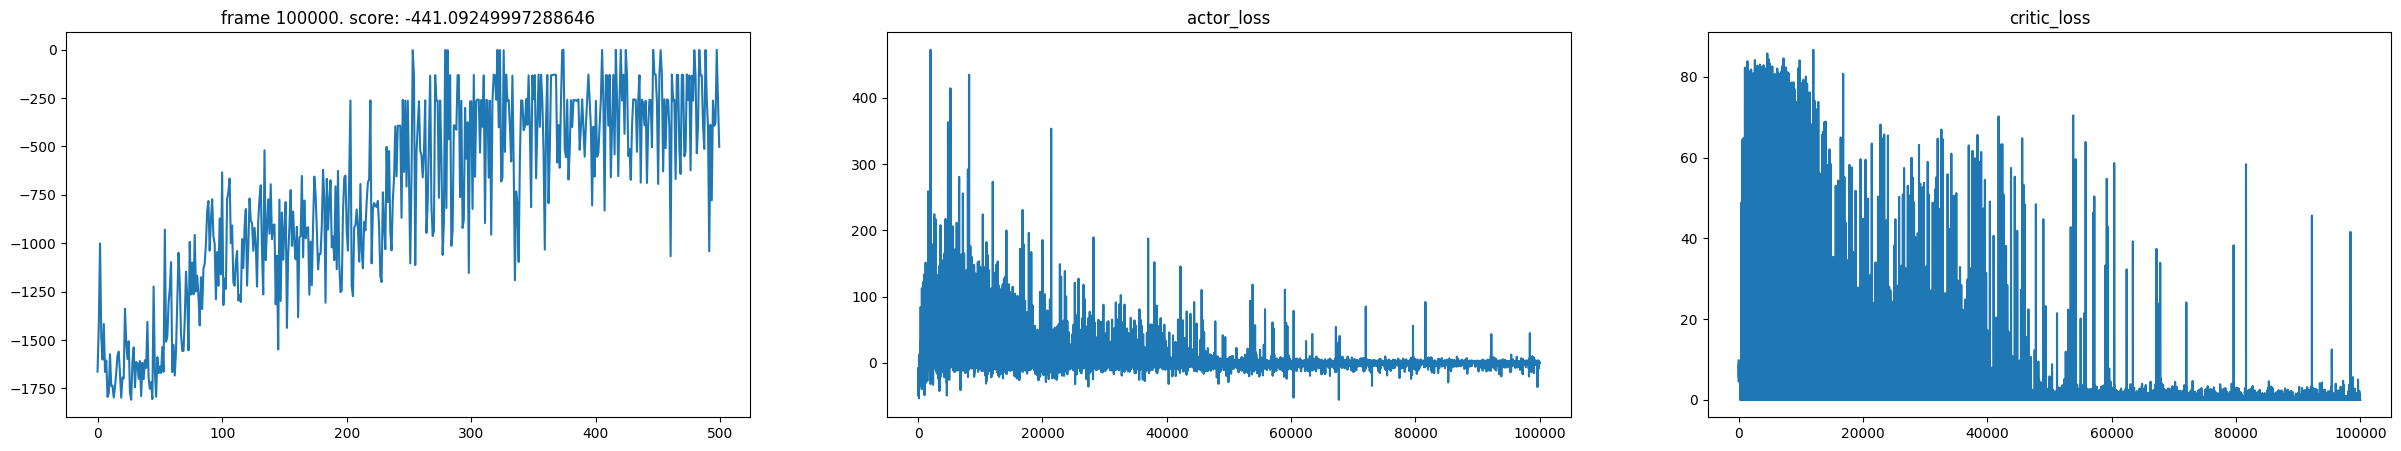

In [6]:
agent.train(num_frames)

In [8]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display

env = gym.make('Pendulum-v1')
def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))


# display 
frames = agent.test()
# display_frames_as_gif(frames)

score:  -131.86335520459707
